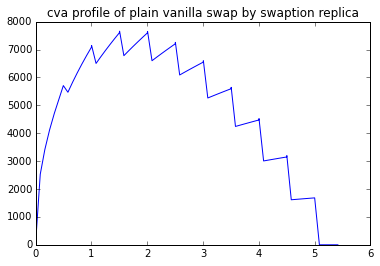

In [3]:
import re
import datetime
from math             import exp, sqrt
from qfin_calendar    import *
from qfin_ir_classes  import *
from qfin_pocket      import *

# spostare in ir_classes
from qfin_swap        import Swap, EPE_Swaption

In [4]:
class GPPDiscountCurve():
    def __init__(self,  dc, a, sigma, x_t, simulDate):
        self.__dc            = dc
        self.__a             = a
        self.__inv_a         = 1/a
        self.__sigma         = sigma
        self.__sigma_2       = sigma*sigma
        self.__sigma2a2      = 0.5*sigma*sigma/(a*a)
        self.__simulDate     = simulDate
        self.__PM_0t         = dc.df(simulDate)
        
        self.__inv_PM_0t     = 1.0/self.__PM_0t
        self.__x_t           = x_t
        #
        self.__year_fract    = YearFractionFactory.create_istance(day_count_basis.basis_lin_act_365) 
        self.__t             = self.__year_fract(self.__dc.obsdate(), simulDate)
        self.__1_giorno      = addTimeInterval(1, 'd')
        self.__B0t_2         = (self.__inv_a * (1.0 - exp(-self.__a*self.__t)))**2
        #
        PM_0T                = self.__PM_0t     
        PM_0T1               = self.__dc.df(self.__simulDate + self.__1_giorno)
        f_M0T                = - self.__inv_PM_0t*(PM_0T1 - PM_0T)*365.0
        self.__phi           = f_M0T + 0.5 * self.__sigma_2 * self.__B0t_2
        #
        self.__exp_a         = exp(self.__a*self.__t)
        exp_ma               = exp(-self.__a*self.__t)
        exp_m2a              = exp_ma * exp_ma
        self.__V0t           = (self.__t + 2.0*self.__inv_a*exp_ma- 0.5*self.__inv_a*exp_m2a-1.5*self.__inv_a)  
        self.__2_inv_a       = 2.0 * self.__inv_a
        self.__05_inv_a      = 0.5 * self.__inv_a
        self.__15_inv_a      = 1.5 * self.__inv_a
        self.__A = {}
        self.__BtT = {}
        
    def update(self, x, simulDate):
        self.__t            = self.__year_fract(self.__dc.obsdate(), simulDate)
        self.__x_t          = x
        self.__simulDate    = simulDate
        self.__PM_0t        = self.__dc.df(simulDate)
    
    def df(self, date_T):
        index = (self.__simulDate, date_T)
        x_t         = self.__x_t
        if index in self.__A:
            A       = self.__A[index]
            BtT     = self.__BtT[index]
        else:
            T           = self.__year_fract(self.__dc.obsdate(), date_T)
            PM_0T       = self.__dc.df(date_T)
             
            inv_PM_0t   = self.__inv_PM_0t
            t           = self.__t
            a           = self.__a
            inv_a       = self.__inv_a
            # ----- V(0,T)
            exp_maT     = exp(-a*T)
            exp_m2aT    = exp_maT * exp_maT
            V0T         = (T + self.__2_inv_a*exp_maT - self.__05_inv_a*exp_m2aT-self.__15_inv_a)  
            # ----- V(t,T) 
            delta_t     = T - t
            exp_matT    = exp_maT * self.__exp_a
            exp_m2atT   = exp_matT * exp_matT
            VtT         = (delta_t + self.__2_inv_a*exp_matT - self.__05_inv_a*exp_m2atT-self.__15_inv_a)  
            # ----- A(t,T)
            AtT         = self.__sigma2a2 *(VtT - V0T + self.__V0t)
            A           = PM_0T * inv_PM_0t * exp(AtT)
            self.__A[index] = A
            # ----- B(t,T)
            BtT         = inv_a * (1.0-exp_matT)
            self.__BtT[index] = BtT 
        
        expX        = exp( - BtT * x_t)
        df          = A * expX
        return  df
    
    def phi(self):
        return self.__phi
    
    def obsdate(self):
        return self.__simulDate


In [5]:
today           = datetime.date(2014,10,24)
#        
# create evaluation date discount curve
#
# starting value for short rate
spot_rate       =   0.02
fardate         = today + addTimeInterval(10.0, 'y')
year_fraction   = YearFractionFactory.create_istance(day_count_basis.basis_lin_act_365)
df              = 1.0 / ((1.0 + spot_rate / 365.0) **(year_fraction(today, fardate) * 365.0))
crv_today       = DiscountCurve(today, [fardate], [df])
#
gpp_k           = 0.1
gpp_sigma       = 0.007

cds_spread      = 0.05
recovery_rate   = 0.4

mc_runs         = 1000

In [6]:
year_fraction   = YearFractionFactory.create_istance(day_count_basis.basis_lin_act_365)
#
# initial values
#
libor_schedule  = LiborScheduler(fixing_lag = 2, day_count = day_count_basis.basis_lin_act_360, start_adj = AdjustmentType.FOLLOWING, end_adj = AdjustmentType.MODFOLLOWING, end_to_end = True)
gpp_dc          = GPPDiscountCurve(crv_today, 
                                   gpp_k, 
                                   gpp_sigma, 
                                   0, 
                                   today)
libor_calc      = LiborForwardCalculator(gpp_dc, libor_schedule)
libor_indx      = Libor(today, 0.0, '6m', libor_calc, 'EURIBOR 6M')
#
# create test swap
#
swap            = Swap(today, 
                       libor_indx, 
                       '5y',                # maturity
                       0.02,                # strike rate
                       notional = 1000000, 
                       pay_fix = +1, 
                       pay_float = -1, 
                       float_tenor='6m', 
                       fixed_tenor='6m')

fixing_dates    = [f.fixing_date() for l in swap.legs() for f in l.flows() if f.index() != None]
#
# maturities set generator
#
time_range      = xrange(1, 12 * 5 + 6, 1)
sim_dates       = [today] + [today + addTimeInterval(x, 'm') for x in time_range]
#
# add fixing dates to simulation dates
#        
sim_dates       = set(sim_dates)
sim_dates.update(fixing_dates)
sim_dates       = sorted(sim_dates)
#
# calculation of simulation times according to the year fraction convention chosen
# 
sim_times       = [year_fraction(today, d) for d in sim_dates]
sim_times       = np.array(sim_times)
#
#-------------------------------------------------------------------------------------------------------------------
# we generate a matrix Nsim x len(T) of standard normal random numbers
# seed is fixed just to get always the same result
#
np.random.seed(1)
stdnorm = np.random.standard_normal(size=(mc_runs,len(sim_times)-1))
#
fwdMat      =   np.zeros(shape=len(sim_times))
fwdMat[0]   =   gpp_dc.phi()
numeraire   =   np.zeros(shape=len(sim_times))
#
# npv matrix
npvMat= [ [ 0 for i in xrange(len(sim_times)) ] for nSim in xrange(mc_runs) ]
# short rate and discount curve simulation loop
r = gpp_dc.phi()
var_factor = 0.5*(gpp_sigma*gpp_sigma/gpp_k)


In [7]:
for nSim in xrange(mc_runs):
    x_s = 0
    for nT in xrange(1,len(sim_times)):
        # ref. B&M eq. (3.35), (3.37) pg. 73
        t           = sim_times[nT]
        s           = sim_times[nT-1]
        drift       = x_s * exp(-gpp_k*(t-s))
        var         = var_factor*(1-exp(-2*gpp_k*(t-s)))
        x_t         = drift + stdnorm[nSim,nT-1] * sqrt(var)
        # updating curve
        gpp_dc.update(x_t, sim_dates[nT])
        fwdMat[nT]  = libor_indx.forward(sim_dates[nT])     
        # computing numeraire
        numeraire[nT] = numeraire[nT-1] + r * (t - s)
        #
        table = Table1D(sim_dates, fwdMat)
        fixed = {'EURIBOR 6M':table}
        price = swap.price(fixed, gpp_dc, sim_dates[nT])
        npvMat[nSim][nT] = price['npv'] * np.exp(-numeraire[nT])
        #
        r = x_t + gpp_dc.phi()
        x_s = x_t
        
npvMat=np.array(npvMat)
npvMat[npvMat<0]=0
EPE = np.mean(npvMat,axis=0)
     
#calculate CVA
sum_cva=0
for i in xrange(len(sim_times)-1):
    sum_cva=sum_cva + EPE[i] *                             \
     (exp(-cds_spread*sim_times[i]  /(1.0-recovery_rate))- \
      exp(-cds_spread*sim_times[i+1]/(1.0-recovery_rate))  \
     )
         
CVA = (1.0-recovery_rate)*sum_cva


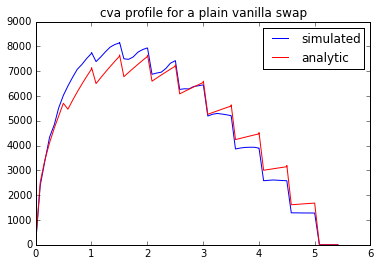

In [8]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

plt.title("cva profile for a plain vanilla swap")
plt.plot(sim_times,EPE, label='simulated')
plt.plot(sim_times,EPE_Swaption,color='red', label='analytic')
plt.legend()
plt.show()
